<a href="https://colab.research.google.com/github/VadimU1/Music-generation/blob/main/music_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом приложении мы сможем генерировать музыкальные ноты с помощью простой рекуррентной нейронной сети (RNN). В качестве датасета мы возьмём коллекцию фортепианных MIDI-файлов из набора данных MAESTRO. Учитывая последовательность нот, модель будет предсказывать следующую ноту в последовательности.

## Установка

Мы будем использовать библиотеку [`pretty_midi`](https://github.com/craffel/pretty-midi) для создания и парсинга MIDI файлов, и [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) для генерации аудио файла в колабе.

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592284 sha256=6ec0499bbf8918535f78de04fe43221dae07910acbc30df0cce7e4d87b9b9349
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Скачиваем датасет Maestro

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 1s 0us/step


В датасете приблизительно 1,200 MIDI файлов.

In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Обработка MIDI файла

Сначала используем ``pretty_midi`` для разбора одного MIDI-файла и проверки формата нот.


In [ ]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2017/MIDI-Unprocessed_055_PIANO055_MID--AUDIO-split_07-07-17_Piano-e_1-04_wav--3.midi


Сгенерируем `PrettyMIDI` объект в качестве образца MIDI файла.

In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

Можем проиграть образец.

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

Запустим распознавание музыкального инструмента

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Извлечение нот

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=61, note_name=C#4, duration=0.2927
1: pitch=65, note_name=F4, duration=0.0656
2: pitch=61, note_name=C#4, duration=0.0615
3: pitch=65, note_name=F4, duration=0.0552
4: pitch=61, note_name=C#4, duration=0.1135
5: pitch=73, note_name=C#5, duration=0.8958
6: pitch=65, note_name=F4, duration=0.0948
7: pitch=61, note_name=C#4, duration=0.0667
8: pitch=65, note_name=F4, duration=0.0958
9: pitch=61, note_name=C#4, duration=0.0552


При обучении модели вы будете использовать три переменные для представления ноты: `pitch`, `step` и `duration`. Высота тона - это воспринимаемое качество звука в виде номера ноты MIDI.
`step` - это время, прошедшее с предыдущей ноты или начала трека.
`duration` - это продолжительность воспроизведения ноты в секундах и разница между временем окончания и начала ноты.


Извлеките ноты из образца MIDI-файла.

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,73,0.928125,1.823958,0.000000,0.895833
1,61,0.977083,1.269792,0.048958,0.292708
2,65,1.310417,1.376042,0.333333,0.065625
3,61,1.447917,1.509375,0.137500,0.061458
4,65,1.564583,1.619792,0.116667,0.055208


Возможно, будет проще интерпретировать названия нот, а не высоту звука, поэтому вы можете использовать приведенную ниже функцию для преобразования числовых значений высоты звука в названия нот. Название ноты показывает тип ноты, случайный звук и номер октавы (например, C#4).

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#5', 'C#4', 'F4', 'C#4', 'F4', 'C#4', 'F4', 'C5', 'C#4', 'F4'],
      dtype='<U3')

Чтобы визуализировать музыкальное произведение, изобразим высоту нот, начало и конец по всей длине трека (например, пиано-ролл). Начнем с первых 100 нот

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

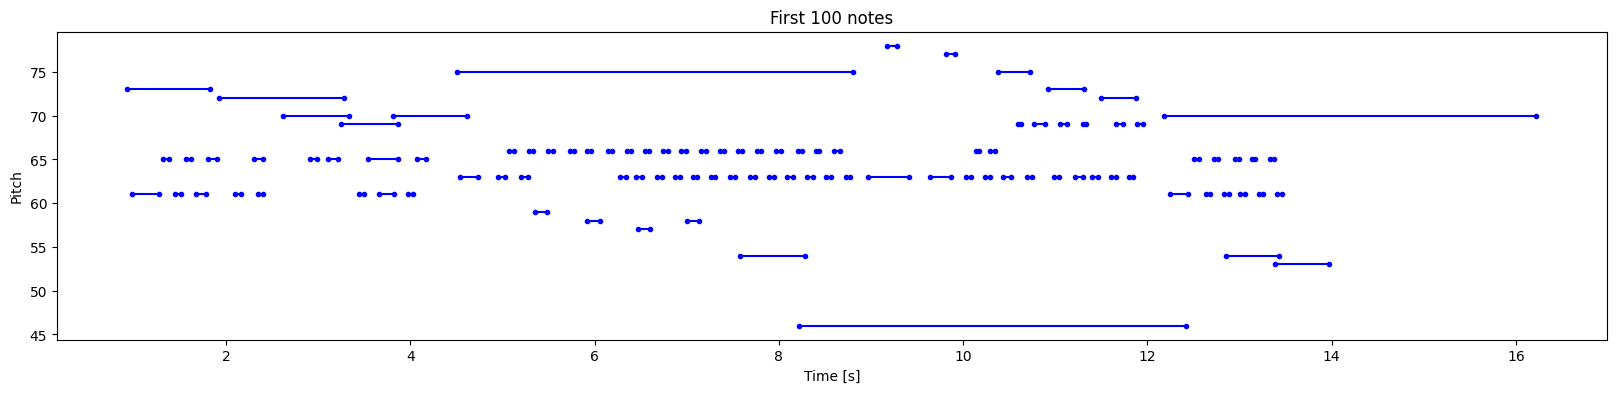

In [ ]:
plot_piano_roll(raw_notes, count=100)

Составим график для всего трека.

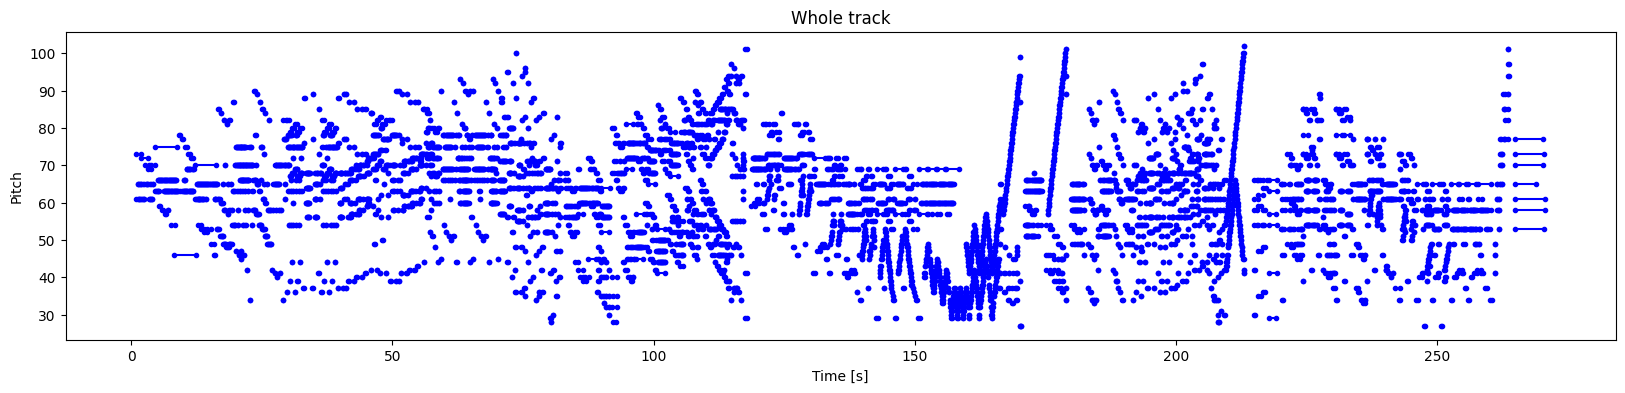

In [ ]:
plot_piano_roll(raw_notes)

Проверим распределение каждой переменной

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

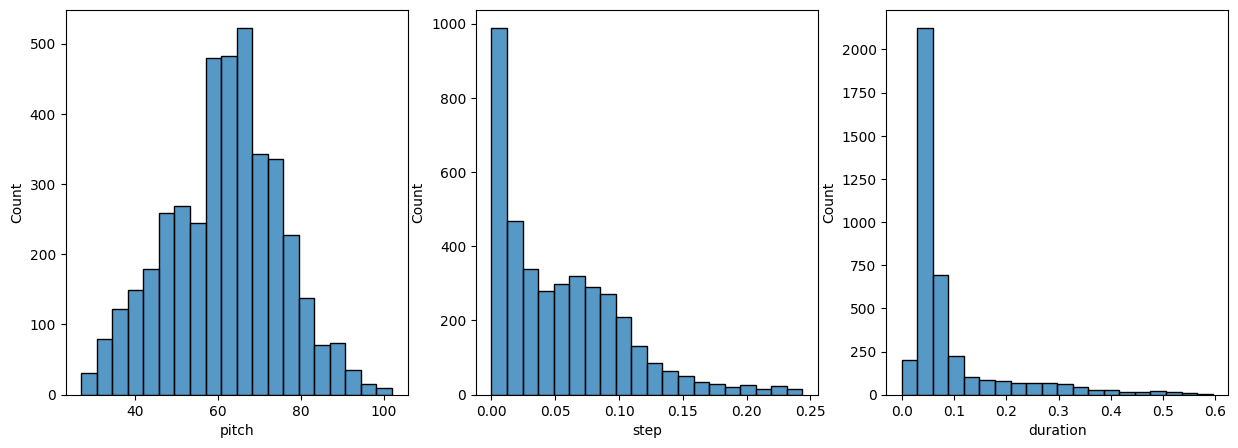

In [ ]:
plot_distributions(raw_notes)

## Создайте MIDI-файл

Вы можете сгенерировать свой собственный MIDI-файл из списка нот, используя приведенную ниже функцию.

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Воспроизведем сгенерированный MIDI-файл и посмотрим, есть ли какая-либо разница.

In [ ]:
display_audio(example_pm)

## Создание обучающего набор данных


Создадим обучающий набор данных, извлекая ноты из MIDI-файлов. Мы начнём с небольшого количества файлов, а позже сможем поэкспериментировать с большим количеством. Это может занять пару минут.

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 17856


Далее создадим `tf.data.Dataset` из парсированных нот.

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Мы будем обучать модель на пакетах последовательностей нот. Каждый пример будет состоять из последовательности нот в качестве входных объектов и следующей ноты в качестве метки. Таким образом, модель будет обучена предсказывать следующую ноту в последовательности.

Мы будем использовать функцию [window](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) с размером `seq_length` для создания объектов и надписей в этом формате.

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Установим длину последовательности для каждого примера разной длины (например, 50, 100, 150), чтобы увидеть, какая из них лучше всего подходит для данных. Размер словаря (`vocab_size`) установлен равным 128, представляющим все высоты тона, поддерживаемые `pretty_midi`.

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

Форма набора данных - ``(100,1)``, что означает, что модель примет 100 заметок в качестве входных данных и научится предсказывать следующую заметку в качестве выходных данных.

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4765625  0.         0.07083333]
 [0.5234375  0.03958333 0.08020833]
 [0.546875   0.03645833 0.1       ]
 [0.6171875  0.03229167 0.05208333]
 [0.59375    0.003125   0.046875  ]
 [0.6640625  0.021875   0.1       ]
 [0.6875     0.03541667 0.06770833]
 [0.734375   0.040625   0.05520833]
 [0.4375     0.58125    0.08333333]
 [0.484375   0.04895833 0.07916667]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=52.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.03750000000000009>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.07916666666666661>}


Загрузим образцы и настроим набор данных для повышения производительности.

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Создайте и обучите модель

Модель будет иметь три выходных сигнала, по одному для каждой переменной note. Для `step` и `duration`, используем пользовательскую функцию потерь, основанную на среднеквадратичной ошибке, которая побуждает модель выводить неотрицательные значения.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

Протестировав функцию `model.evaluate`, вы можете увидеть, что потери `pitch` значительно больше, чем потери `step` и `duration`.
Обратим внимание, что `loss` это общие потери, вычисляемые путем суммирования всех остальных потерь, и в настоящее время преобладают потери `pitch`.

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

278/278 [==============================] - 8s 3ms/step - loss: 5.4608 - duration_loss: 0.5634 - pitch_loss: 4.8534 - step_loss: 0.0441


{'loss': 5.460801601409912,
 'duration_loss': 0.5633568167686462,
 'pitch_loss': 4.853352069854736,
 'step_loss': 0.04409242421388626}

Один из способов сбалансировать это - использовать аргумент `loss_weights` для компиляции:

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

`loss` становится взвешенной суммой индивидуальных потерь.

In [ ]:
model.evaluate(train_ds, return_dict=True)

278/278 [==============================] - 2s 3ms/step - loss: 0.8501 - duration_loss: 0.5634 - pitch_loss: 4.8534 - step_loss: 0.0441


{'loss': 0.8501166105270386,
 'duration_loss': 0.5633568167686462,
 'pitch_loss': 4.853352069854736,
 'step_loss': 0.04409242421388626}

Обучим модель

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
278/278 [==============================] - 7s 8ms/step - loss: 0.3519 - duration_loss: 0.1041 - pitch_loss: 4.1763 - step_loss: 0.0390
Epoch 2/50
278/278 [==============================] - 2s 6ms/step - loss: 0.3332 - duration_loss: 0.0963 - pitch_loss: 4.0035 - step_loss: 0.0367
Epoch 3/50
278/278 [==============================] - 1s 5ms/step - loss: 0.3307 - duration_loss: 0.0946 - pitch_loss: 3.9889 - step_loss: 0.0366
Epoch 4/50
278/278 [==============================] - 1s 5ms/step - loss: 0.3286 - duration_loss: 0.0942 - pitch_loss: 3.9741 - step_loss: 0.0357
Epoch 5/50
278/278 [==============================] - 1s 5ms/step - loss: 0.3254 - duration_loss: 0.0940 - pitch_loss: 3.9356 - step_loss: 0.0346
Epoch 6/50
278/278 [==============================] - 1s 5ms/step - loss: 0.3211 - duration_loss: 0.0925 - pitch_loss: 3.9055 - step_loss: 0.0334
Epoch 7/50
278/278 [==============================] - 1s 5ms/step - loss: 0.3175 - duration_loss: 0.0907 - pitch_loss: 3.878

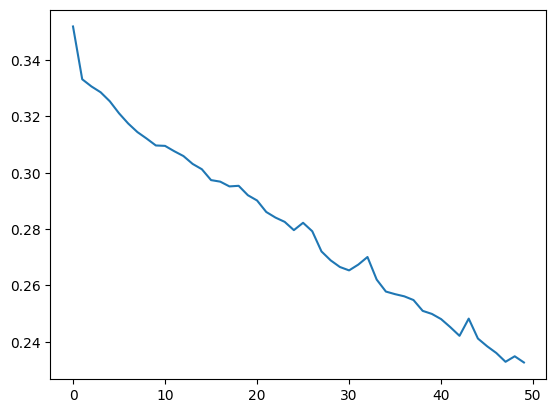

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Сгенерируем ноты

Чтобы использовать модель для создания заметок, сначала нужно будет указать начальную последовательность заметок. Приведенная ниже функция генерирует одну заметку из последовательности заметок.

Что касается высоты тона ноты, то он извлекает выборку из распределения нот softmax, созданного моделью, а не просто выбирает ноту с наибольшей вероятностью.
Постоянный выбор ноты с наибольшей вероятностью приведет к генерированию повторяющихся последовательностей нот.

Параметр `temperature` может использоваться для управления случайностью генерируемых заметок.

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Теперь сгенерируйте несколько заметок. Вы можете поиграть с температурой и начальной последовательностью в "next_notes" и посмотреть, что получится.

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 25ms/step


In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,47,0.247690,0.412445,0.247690,0.660136
1,80,0.225377,0.947435,0.473068,1.420503
2,80,0.204863,1.266406,0.677930,1.944336
3,84,0.209089,0.892226,0.887019,1.779246
4,78,0.212377,0.767044,1.099396,1.866441
5,76,0.202932,0.739302,1.302328,2.041630
6,50,0.197257,0.734640,1.499585,2.234225
7,95,0.180185,0.741982,1.679770,2.421752
8,84,0.205910,0.713200,1.885680,2.598880
9,84,0.204119,0.735740,2.089799,2.825538


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Визуализируем сгенерированные ноты

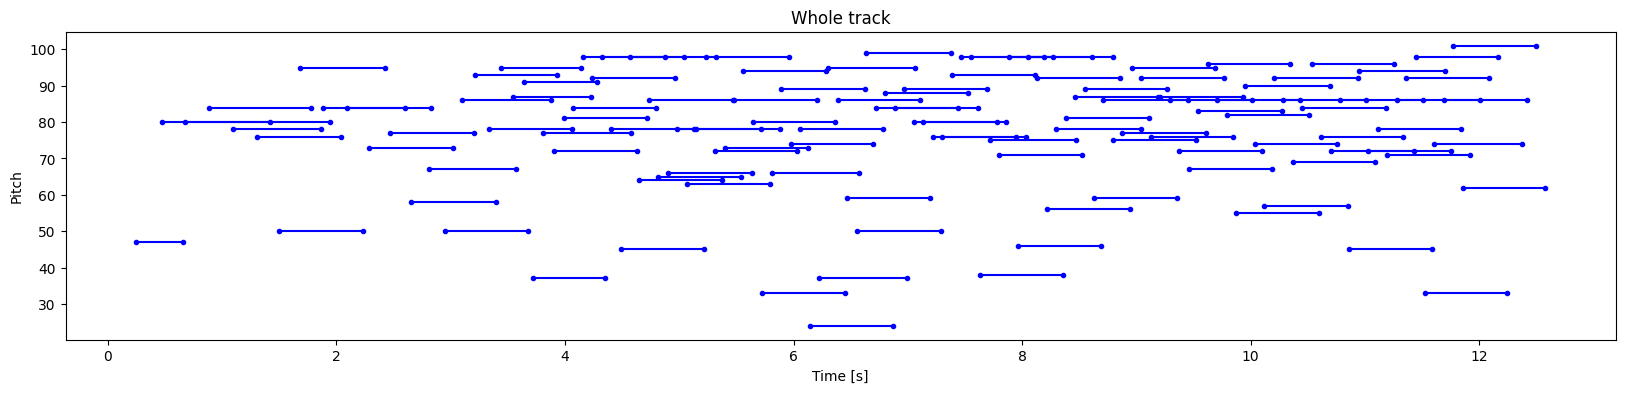

In [ ]:
plot_piano_roll(generated_notes)

Отобразим распределение `pitch`, `step` и `duration`.

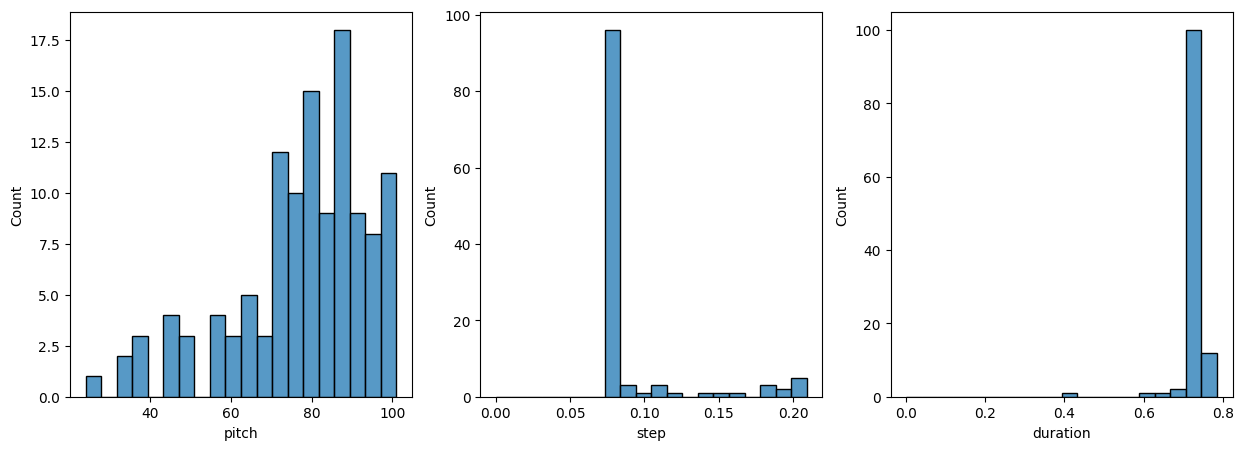

In [ ]:
plot_distributions(generated_notes)

На приведенных выше графиках вы заметите изменение в распределении переменных note.
Поскольку существует петля обратной связи между выходами и входными данными модели, модель стремится генерировать похожие последовательности выходных данных, чтобы уменьшить потери.
Это особенно актуально для `step` и `duration`, в которых используются потери MSE.
Для `pitch`, вы можете увеличить случайность, увеличив `temperature` в `predict_next_note`.
